In [1]:
#필요 라이브러리 호출
import pandas as pd
import numpy as np
from datetime import datetime, timedelta,timezone
import matplotlib.pyplot as plt

import jenkspy

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,StandardScaler,RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN,KMeans

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [2]:
# 데이터 로딩 및 시간데이터 공간데이터 분리 후 시간데이터 ISO8601형태로 변환
df = pd.read_csv('../csv/50area_dummy1_232,000.csv')
time_cols = ['마지막충전종료시간','연결시작시간', '충전시작시간', '충전종료시간', '연결종료시간', '출발예상시간']
evse_cols = ['충전소위치', '충전기이름', '충전기타입','방전지원여부', '예약충전','충전량(kWh)', '요청충전량(kWh)']
df = df[time_cols + evse_cols].copy()
for col in time_cols:
    df[col] = pd.to_datetime(df[col],format='ISO8601')

In [3]:
# 추가 피쳐 컬럼 생성
df['요일'] = df['연결시작시간'].dt.weekday
df['사용하지않은시간'] = df['연결시작시간']-df['마지막충전종료시간'] #충전기 인기 척도
df['사용자예상충전소이용시간'] = df['출발예상시간'] - df['연결시작시간'] 
df['사용자예상충전소요시간차이']= df['출발예상시간'] - df['충전종료시간'] #음의 값이면 사용자 예상 보다 충전이 더 걸림 즉 사용자가 충전 시간을 잘 이해하지 못함
df['실제총충전소이용시간'] = df['연결종료시간']-df['연결시작시간']
df['실제충전시간'] = df['충전종료시간']-df['충전시작시간']
df['충전시작소요시간'] = df['충전시작시간']-df['연결시작시간'] #충전기 꼽꼬 충전 안하는 사람들 충전소의 충전기 이용 신뢰도에 영향을 주는 요인 *********************
df['충전완료후출발소요시간'] = df['연결종료시간']- df['충전종료시간'] #음의 값이면 더 오래 물고 있엇다. 늦게 플러그를 뽑은 사용자 ***********************************
df['실제이용시간과예상출발시간차이'] = df['연결종료시간'] - df['출발예상시간'] #음의 값이면 더 오래 물고 있엇다. 자신이 입력한 예상 출력 시간 보다 늦게 플러그 뽑은 사용자***************************
df['요청충전량차이'] = df['요청충전량(kWh)']-df['충전량(kWh)'] #음의 값이면 실제보다 더 충전 양의 값이면 덜 충전
df['충전량당시간이해관계']= df['사용자예상충전소이용시간']/df['요청충전량(kWh)'] #사용자가 이만큼이면 이정도 쓸꺼야 즉 사용자가 인식하는 충전에 소요되는 시간
df['이용시간당전력사용량'] = df['충전량(kWh)'] / (df['실제충전시간'].dt.total_seconds() / 3600)

In [4]:
# 컬럼 이름 영어명으로 변경
col_rename_map = {
    '마지막충전종료시간': 'last_charge_end_time',
    '연결시작시간': 'connection_start_time',
    '충전시작시간': 'charging_start_time',
    '충전종료시간': 'charging_end_time',
    '연결종료시간': 'connection_end_time',
    '출발예상시간': 'expected_departure_time',
    '충전소위치': 'station_location',
    '충전기이름': 'evse_name',
    '충전기타입': 'evse_type',
    '방전지원여부': 'supports_discharge',
    '예약충전': 'scheduled_charge',
    '충전량(kWh)': 'delivered_kwh',
    '요청충전량(kWh)': 'requested_kwh',
    '요일': 'weekday',
    '사용하지않은시간': 'idle_time',
    '사용자예상충전소이용시간': 'expected_usage_duration',
    '사용자예상충전소요시간차이': 'expected_time_diff',
    '실제총충전소이용시간': 'actual_usage_duration',
    '실제충전시간': 'actual_charging_duration',
    '충전시작소요시간': 'start_delay_duration',
    '충전완료후출발소요시간': 'post_charge_departure_delay',
    '실제이용시간과예상출발시간차이': 'usage_departure_time_diff',
    '요청충전량차이': 'kwh_request_diff',
    '충전량당시간이해관계': 'duration_per_kwh',
    '이용시간당전력사용량': 'kwh_per_usage_time',
}

df.rename(columns=col_rename_map, inplace=True)

In [5]:
#훈련용 테이블 생성
df_train = pd.DataFrame()

In [6]:
#시간데이터 모두 초 단위로 통일 및 없는 값은 missing으로 매칭 missing이 의미 있는 가 있을수 있음
for col in df.columns:
    if pd.api.types.is_timedelta64_dtype(df[col]):
        df_train[f'{col}_ts'] = df[col].apply(lambda x: int(x.total_seconds()) if pd.notnull(x) else 0).astype('int64')
        df_train[f'{col}_missing'] = df[col].isnull().astype(bool)

    elif pd.api.types.is_datetime64_any_dtype(df[col]):
        df_train[f'{col}_ts'] = df[col].apply(lambda x: int(x.timestamp()) if pd.notnull(x) else 0).astype('int64')
        df_train[f'{col}_missing'] = df[col].isnull().astype(bool)

In [7]:
# jenkins 등급화 작업 구간화 -  실제이용시간과예상출발시간차이  -  값이 작을 수록 출발 예정 보다 빨리 출발함 1등급 빨리 이용가능 -> 5등급 사용중이거나 오래 기다려야함
data = df_train['usage_departure_time_diff_ts'].values
usage_departure_range = jenkspy.jenks_breaks(data,n_classes=5)
# jenkins 등급화 작업 구간화 - 충전완료후출발소요시간  - 값이 작을 수록 빨리 출발 한것 값이 클 수록 지연 됨  1등급 빨리 이용가능 -> 5등급 사용중이거나 오래 기다려야함
data = df_train['post_charge_departure_delay_ts'].values
post_charge_departure_range = jenkspy.jenks_breaks(data,n_classes=5)
print('post_charge_departure_range : ',post_charge_departure_range)
print('usage_departure_range',usage_departure_range)

post_charge_departure_range :  [np.int64(0), np.int64(1659), np.int64(3140), np.int64(5361), np.int64(9496), np.int64(36000)]
usage_departure_range [np.int64(-6900), np.int64(-1096), np.int64(891), np.int64(2955), np.int64(6454), np.int64(37380)]


In [8]:
# 등급에 따른 분류 작업 pd.cut(df[col],include_lowest=True,bins=range,lables=label).astype(int)
label = [1,2,3,4,5]
df['usage_departure_range'] = pd.cut(df_train['usage_departure_time_diff_ts'], include_lowest=True, bins=usage_departure_range, labels=label).astype(int)
df['post_charge_departure_range'] = pd.cut(df_train['post_charge_departure_delay_ts'],include_lowest=True,bins=post_charge_departure_range,labels=label).astype(int)
# pd.concat([df[['expected_departure_time', 'connection_end_time', 'usage_departure_time_diff', 'usage_departure_range']] ,df_train['usage_departure_time_diff_ts']],axis=1)
# pd.concat([df[['charging_end_time','connection_end_time','post_charge_departure_delay','post_charge_departure_range']],df_train['post_charge_departure_delay_ts']],axis=1)

In [9]:
#필요없는 컬럼 드랍
droplist = ['last_charge_end_time_missing','connection_start_time_missing','connection_end_time_missing','idle_time_missing','actual_usage_duration_missing']
df_train = df_train.drop(droplist,axis=1,errors='ignore')

In [10]:
#결측치 체크
df['kwh_per_usage_time'] = df['kwh_per_usage_time'].fillna(0)
df['kwh_per_usage_time_missing'] = df['kwh_per_usage_time'].isnull().astype(bool)

In [11]:
#수치형 컬럼 합치기
numberic_col = ['delivered_kwh','requested_kwh','kwh_request_diff','kwh_per_usage_time','kwh_per_usage_time_missing']
df_train = pd.concat([df_train, df[numberic_col]], axis=1)

In [12]:
#훈련 데이터 스케일 원핫 처리 컬럼 합치기
onehot_col = ['station_location','evse_name','evse_type','supports_discharge','scheduled_charge','weekday','usage_departure_range','post_charge_departure_range']
#  df_train에 onehot 대상 컬럼 먼저 붙이기
df_train = pd.concat([df_train, df[onehot_col]], axis=1)
# scale 대상은 df_train 전체에서 onehot 제외한 컬럼으로
scale_col = df_train.columns.difference(onehot_col).tolist()

총 정보 보존율은 PCA(주성분 분석)가 원본 데이터의 **얼마나 많은 정보(=분산)**<br/>
예를 들어, 원래 차원(피쳐)이 100개인데, 65% 설명력을 갖는 데 필요한 주성분이 10개라면 → 10차원으로 축소됨.<br/>
각 주성분 보존율은 **서로 다른 방향(축)**에서 **데이터의 분산(정보량)**을 가장 잘 설명하는 축

# 1차 PCA
## Minmaxscaler 사용
- 	0~1로 정규화
- 변수 분포가 치우쳐 있거나 이상치가 많을 경우 성능 저하 가능성
### PCA 결과
- 선택된 주성분 수: 3
- 각 주성분 보존율: [0.1353293  0.1212487  0.06185882]
- 총 보존율: 0.318436823297534
> ▶️ PC1 (설명력: 0.1353) 상위 기여 변수:<br/>
  scaling__expected_usage_duration_missing → 기여도: 0.3228<br/>
  scaling__expected_time_diff_missing → 기여도: 0.3228<br/>
  scaling__expected_departure_time_missing → 기여도: 0.3228<br/>
  scaling__duration_per_kwh_missing → 기여도: 0.3228<br/>
  scaling__usage_departure_time_diff_missing → 기여도: 0.3228<br/>

>▶️ PC2 (설명력: 0.1212) 상위 기여 변수:<br/>
  onehot__evse_type_FC           → 기여도: 0.4315<br/>
  onehot__evse_type_SC           → 기여도: -0.4315<br/>
  scaling__actual_charging_duration_ts → 기여도: -0.3546<br/>
  onehot__supports_discharge_n   → 기여도: 0.3446<br/>
  onehot__supports_discharge_y   → 기여도: -0.3446<br/>

>▶️ PC3 (설명력: 0.0619) 상위 기여 변수:<br/>
  onehot__post_charge_departure_range_1 → 기여도: 0.6783<br/>
  onehot__post_charge_departure_range_2 → 기여도: -0.5169<br/>
  onehot__usage_departure_range_3 → 기여도: -0.2878<br/>
  onehot__usage_departure_range_2 → 기여도: 0.2810<br/>
  onehot__post_charge_departure_range_3 → 기여도: -0.1333<br/>

In [13]:
#데이터 처리
ct = ColumnTransformer(
    [
        ('scaling',MinMaxScaler(),scale_col),
        ('onehot',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),onehot_col)
    ]
)
X = ct.fit_transform(df_train)

In [14]:
#처리 데이터 프레임으로 
feature_name = ct.get_feature_names_out()
x_df = pd.DataFrame(X,columns=feature_name)

In [15]:
# 성분 3개로 구성 정보보존율 30프로
pca = PCA(n_components=3)
x_pca = pca.fit_transform(X)
print("선택된 주성분 수:", pca.n_components_)
print("각 주성분 보존율:", pca.explained_variance_ratio_)
print("총 보존율:", sum(pca.explained_variance_ratio_))

선택된 주성분 수: 3
각 주성분 보존율: [0.1353293  0.1212487  0.06185882]
총 보존율: 0.318436823297534


In [16]:
# 주성분 별 변수 기여도 pd보기 
compo = pd.DataFrame(
    pca.components_.T,
    columns=[f'PCA{i}' for i in range(len(pca.components_))],
    index=ct.get_feature_names_out()
)
compo

,PCA0,PCA1,PCA2
scaling__actual_charging_duration_missing,0.018735,-0.007473,0.005685
scaling__actual_charging_duration_ts,-0.191286,-0.354627,-0.011472
scaling__actual_usage_duration_ts,-0.050865,-0.086548,-0.030948
scaling__charging_end_time_missing,0.018735,-0.007473,0.005685
scaling__charging_end_time_ts,-0.018272,0.007342,-0.005416
...,...,...,...
onehot__post_charge_departure_range_1,0.065109,-0.043082,0.678325
onehot__post_charge_departure_range_2,-0.032876,0.022702,-0.516871
onehot__post_charge_departure_range_3,-0.025492,0.017461,-0.133285
onehot__post_charge_departure_range_4,-0.006061,0.003174,-0.024958


In [17]:
# 주성분 별 변수 기여도 보기
components = pca.components_
for i, component in enumerate(components):
    print(f"\n▶️ PC{i+1} (설명력: {pca.explained_variance_ratio_[i]:.4f}) 상위 기여 변수:")
    # 가장 영향 큰 변수 Top 5
    loading_scores = pd.Series(component, index=ct.get_feature_names_out())
    sorted_scores = loading_scores.abs().sort_values(ascending=False)
    for feature in sorted_scores.head(5).index:
        print(f"  {feature:30s} → 기여도: {loading_scores[feature]:.4f}")


▶️ PC1 (설명력: 0.1353) 상위 기여 변수:
  scaling__expected_usage_duration_missing → 기여도: 0.3228
  scaling__expected_time_diff_missing → 기여도: 0.3228
  scaling__expected_departure_time_missing → 기여도: 0.3228
  scaling__duration_per_kwh_missing → 기여도: 0.3228
  scaling__usage_departure_time_diff_missing → 기여도: 0.3228

▶️ PC2 (설명력: 0.1212) 상위 기여 변수:
  onehot__evse_type_FC           → 기여도: 0.4315
  onehot__evse_type_SC           → 기여도: -0.4315
  scaling__actual_charging_duration_ts → 기여도: -0.3546
  onehot__supports_discharge_n   → 기여도: 0.3446
  onehot__supports_discharge_y   → 기여도: -0.3446

▶️ PC3 (설명력: 0.0619) 상위 기여 변수:
  onehot__post_charge_departure_range_1 → 기여도: 0.6783
  onehot__post_charge_departure_range_2 → 기여도: -0.5169
  onehot__usage_departure_range_3 → 기여도: -0.2878
  onehot__usage_departure_range_2 → 기여도: 0.2810
  onehot__post_charge_departure_range_3 → 기여도: -0.1333


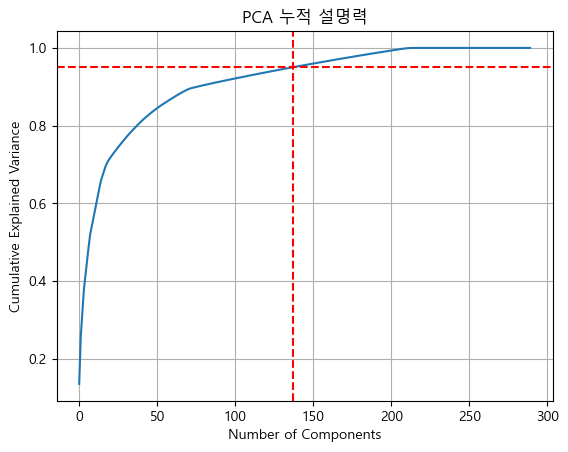

In [18]:
pca = PCA().fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumsum)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--')
plt.axvline(x=np.argmax(cumsum >= 0.95), color='r', linestyle='--')
plt.title("PCA 누적 설명력")
plt.show()


In [19]:
#분산 90프로
pca = PCA(n_components=0.9)
x_pca = pca.fit_transform(X)
print("선택된 주성분 수:", pca.n_components_)
print("각 주성분 보존율:", pca.explained_variance_ratio_)
print("총 보존율:", sum(pca.explained_variance_ratio_))

선택된 주성분 수: 77
각 주성분 보존율: [0.1353293  0.1212487  0.06185882 0.05949883 0.03676278 0.03642136
 0.03574785 0.03243004 0.02038073 0.02026998 0.02023479 0.02021277
 0.02019009 0.02014271 0.01863802 0.01270878 0.01233578 0.01225491
 0.0083705  0.00731164 0.0056891  0.00554397 0.00541498 0.00534757
 0.00525624 0.00515721 0.0050997  0.00503116 0.00496477 0.00485388
 0.00476526 0.00466131 0.0045185  0.00436361 0.00432816 0.0043213
 0.00418102 0.00407344 0.0040624  0.00402516 0.00394216 0.00374045
 0.00356488 0.00347378 0.00338308 0.00337357 0.00330867 0.00318672
 0.00314625 0.00306415 0.00299916 0.0029114  0.00278442 0.00271413
 0.00264393 0.00259965 0.0025883  0.00256105 0.00255117 0.00253747
 0.00250694 0.00247821 0.0024642  0.00241718 0.00235716 0.00231891
 0.00223113 0.00215471 0.00207419 0.00198122 0.00189209 0.00148925
 0.00115539 0.00100582 0.00100193 0.00097439 0.00095972]
총 보존율: 0.9005439523847202


In [20]:
#분산 65프로
pca = PCA(n_components=0.65)
x_pca = pca.fit_transform(X)
print("선택된 주성분 수:", pca.n_components_)
print("각 주성분 보존율:", pca.explained_variance_ratio_)
print("총 보존율:", sum(pca.explained_variance_ratio_))

선택된 주성분 수: 15
각 주성분 보존율: [0.1353293  0.1212487  0.06185882 0.05949883 0.03676278 0.03642136
 0.03574785 0.03243004 0.02038073 0.02026998 0.02023479 0.02021277
 0.02019009 0.02014271 0.01863802]
총 보존율: 0.6593667515934472


In [21]:
compo = pd.DataFrame(
    pca.components_.T,
    columns=[f'PCA{i}' for i in range(len(pca.components_))],
    index=ct.get_feature_names_out()
)
compo

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,PCA13,PCA14
scaling__actual_charging_duration_missing,0.018735,-0.007473,0.005685,-0.000266,-0.012688,-0.001285,-0.002561,0.014917,-0.000979,0.000032,-0.000217,-0.000024,-0.001187,-0.000216,0.009602
scaling__actual_charging_duration_ts,-0.191286,-0.354627,-0.011472,0.000377,0.178069,-0.192668,-0.015416,0.045594,0.002257,0.002023,-0.000630,-0.000824,0.000939,-0.002256,-0.011792
scaling__actual_usage_duration_ts,-0.050865,-0.086548,-0.030948,0.001366,0.025580,-0.074376,0.000734,-0.023460,0.000489,0.000250,0.000056,0.000075,-0.000020,-0.000462,-0.002438
scaling__charging_end_time_missing,0.018735,-0.007473,0.005685,-0.000266,-0.012688,-0.001285,-0.002561,0.014917,-0.000979,0.000032,-0.000217,-0.000024,-0.001187,-0.000216,0.009602
scaling__charging_end_time_ts,-0.018272,0.007342,-0.005416,0.000350,0.017828,0.002290,0.055638,-0.011153,0.001183,0.000121,0.000272,-0.000343,0.001345,0.000256,-0.008611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
onehot__post_charge_departure_range_1,0.065109,-0.043082,0.678325,-0.032149,-0.056485,0.039996,-0.015610,0.373767,-0.001331,0.004835,0.002000,-0.002623,-0.000618,0.001620,0.068391
onehot__post_charge_departure_range_2,-0.032876,0.022702,-0.516871,0.025187,0.436671,0.413149,-0.059942,0.015583,-0.003319,0.002531,0.003587,-0.000654,0.002233,0.004386,0.162381
onehot__post_charge_departure_range_3,-0.025492,0.017461,-0.133285,0.005849,-0.321764,-0.369500,0.060656,-0.263906,0.010142,-0.011931,-0.008045,0.002112,-0.000906,-0.012715,-0.382474
onehot__post_charge_departure_range_4,-0.006061,0.003174,-0.024958,0.001448,-0.053137,-0.076646,0.012960,-0.115385,-0.005939,0.004733,0.002230,-0.000286,-0.000451,0.006508,0.138499


# 2차 PCA
## Robustscaler 사용
- 중앙값 기준 정규화 (이상치 민감도 ↓)
- 이상치 영향 최소화, 주성분에서 가장 많은 분산 보존
### PCA 결과

- 선택된 주성분 수: 3
- 각 주성분 보존율: [0.67055733 0.11416112 0.03745587]
- 총 보존율: 0.822174326584484

>▶️ PC1 (설명력:0.6706) 상위 기여 변수<br/>
  scaling__expected_departure_time_ts → 기여도: 0.9805<br/>
  scaling__charging_end_time_ts  → 기여도: 0.0770<br/>
  scaling__charging_start_time_ts → 기여도: 0.0770<br/>
  scaling__expected_departure_time_missing → 기여도: -0.0571<br/>
  scaling__usage_departure_time_diff_missing → 기여도: -0.0571<br/>

>▶️ PC2 (설명력:0.1142) 상위 기여 변수<br/>
  scaling__charging_end_time_ts  → 기여도: 0.6883<br/>
  scaling__charging_start_time_ts → 기여도: 0.6883<br/>
  scaling__expected_departure_time_ts → 기여도: -0.1082<br/>
  scaling__requested_kwh         → 기여도: 0.0762<br/>
  scaling__delivered_kwh         → 기여도: 0.0729<br/>

>▶️ PC3 (설명력:0.0375) 상위 기여 변수<br/>
  scaling__usage_departure_time_diff_ts → 기여도: 0.6852<br/>
  scaling__post_charge_departure_delay_ts → 기여도: 0.5958<br/>
  scaling__expected_time_diff_ts → 기여도: -0.2266<br/>
  onehot__post_charge_departure_range_1 → 기여도: -0.1958<br/>
  scaling__actual_usage_duration_ts → 기여도: 0.1490<br/>

### PCA 조정 
- 선택된 주성분 수: 7
- 각 주성분 보존율: [0.67055733 0.11416112 0.03745587 0.02734959 0.02331214 0.015148380.01357226]
- 총 보존율: 0.9015566968875924

>▶️ PC1 (설명력:0.6706) 상위 기여 변수<br/>
  scaling__expected_departure_time_ts → 기여도: 0.9805<br/>
  scaling__charging_end_time_ts  → 기여도: 0.0770<br/>
  scaling__charging_start_time_ts → 기여도: 0.0770<br/>
  scaling__expected_departure_time_missing → 기여도: -0.0571<br/>
  scaling__usage_departure_time_diff_missing → 기여도: -0.0571<br/>

>▶️ PC2 (설명력:0.1142) 상위 기여 변수<br/>
  scaling__charging_end_time_ts  → 기여도: 0.6883<br/>
  scaling__charging_start_time_ts → 기여도: 0.6883<br/>
  scaling__expected_departure_time_ts → 기여도: -0.1082<br/>
  scaling__requested_kwh         → 기여도: 0.0762<br/>
  scaling__delivered_kwh         → 기여도: 0.0729<br/>

>▶️ PC3 (설명력:0.0375) 상위 기여 변수<br/>
  scaling__usage_departure_time_diff_ts → 기여도: 0.6852<br/>
  scaling__post_charge_departure_delay_ts → 기여도: 0.5958<br/>
  scaling__expected_time_diff_ts → 기여도: -0.2266<br/>
  onehot__post_charge_departure_range_1 → 기여도: -0.1958<br/>
  scaling__actual_usage_duration_ts → 기여도: 0.1490<br/>


In [22]:
ct = ColumnTransformer(
    [
        ('scaling',RobustScaler(),scale_col),
        ('onehot',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),onehot_col)
    ]
)
X = ct.fit_transform(df_train)

In [23]:
# 성분 3개로 구성 정보보존율 30프로
pca = PCA(n_components=3)
x_pca = pca.fit_transform(X)
print("선택된 주성분 수:", pca.n_components_)
print("각 주성분 보존율:", pca.explained_variance_ratio_)
print("총 보존율:", sum(pca.explained_variance_ratio_))

선택된 주성분 수: 3
각 주성분 보존율: [0.67055733 0.11416112 0.03745587]
총 보존율: 0.822174326584484


In [24]:
components = pca.components_
for i, component in enumerate(components):
    print(f'\n▶️ PC{i+1} (설명력:{pca.explained_variance_ratio_[i]:.4f}) 상위 기여 변수')
    loading_scores = pd.Series(component,index=ct.get_feature_names_out())
    sorted_score = loading_scores.abs().sort_values(ascending=False)
    for feature in sorted_score.head(5).index:
        print(f"  {feature:30s} → 기여도: {loading_scores[feature]:.4f}")


▶️ PC1 (설명력:0.6706) 상위 기여 변수
  scaling__expected_departure_time_ts → 기여도: 0.9805
  scaling__charging_end_time_ts  → 기여도: 0.0770
  scaling__charging_start_time_ts → 기여도: 0.0770
  scaling__expected_departure_time_missing → 기여도: -0.0571
  scaling__usage_departure_time_diff_missing → 기여도: -0.0571

▶️ PC2 (설명력:0.1142) 상위 기여 변수
  scaling__charging_end_time_ts  → 기여도: 0.6883
  scaling__charging_start_time_ts → 기여도: 0.6883
  scaling__expected_departure_time_ts → 기여도: -0.1082
  scaling__requested_kwh         → 기여도: 0.0762
  scaling__delivered_kwh         → 기여도: 0.0729

▶️ PC3 (설명력:0.0375) 상위 기여 변수
  scaling__usage_departure_time_diff_ts → 기여도: 0.6852
  scaling__post_charge_departure_delay_ts → 기여도: 0.5958
  scaling__expected_time_diff_ts → 기여도: -0.2266
  onehot__post_charge_departure_range_1 → 기여도: -0.1958
  scaling__actual_usage_duration_ts → 기여도: 0.1490


In [25]:
# 성분 3개로 구성 정보보존율 30프로
pca = PCA(n_components=0.9)
x_pca = pca.fit_transform(X)
print("선택된 주성분 수:", pca.n_components_)
print("각 주성분 보존율:", pca.explained_variance_ratio_)
print("총 보존율:", sum(pca.explained_variance_ratio_))

선택된 주성분 수: 7
각 주성분 보존율: [0.67055733 0.11416112 0.03745587 0.02734959 0.02331214 0.01514838
 0.01357226]
총 보존율: 0.9015566968875924


In [26]:
components = pca.components_
for i, component in enumerate(components):
    print(f'\n▶️ PC{i+1} (설명력:{pca.explained_variance_ratio_[i]:.4f}) 상위 기여 변수')
    loading_scores = pd.Series(component,index=ct.get_feature_names_out())
    sorted_score = loading_scores.abs().sort_values(ascending=False)
    for feature in sorted_score.head(5).index:
        print(f"  {feature:30s} → 기여도: {loading_scores[feature]:.4f}")


▶️ PC1 (설명력:0.6706) 상위 기여 변수
  scaling__expected_departure_time_ts → 기여도: 0.9805
  scaling__charging_end_time_ts  → 기여도: 0.0770
  scaling__charging_start_time_ts → 기여도: 0.0770
  scaling__expected_departure_time_missing → 기여도: -0.0571
  scaling__usage_departure_time_diff_missing → 기여도: -0.0571

▶️ PC2 (설명력:0.1142) 상위 기여 변수
  scaling__charging_end_time_ts  → 기여도: 0.6883
  scaling__charging_start_time_ts → 기여도: 0.6883
  scaling__expected_departure_time_ts → 기여도: -0.1082
  scaling__requested_kwh         → 기여도: 0.0762
  scaling__delivered_kwh         → 기여도: 0.0729

▶️ PC3 (설명력:0.0375) 상위 기여 변수
  scaling__usage_departure_time_diff_ts → 기여도: 0.6852
  scaling__post_charge_departure_delay_ts → 기여도: 0.5958
  scaling__expected_time_diff_ts → 기여도: -0.2266
  onehot__post_charge_departure_range_1 → 기여도: -0.1958
  scaling__actual_usage_duration_ts → 기여도: 0.1490

▶️ PC4 (설명력:0.0273) 상위 기여 변수
  scaling__kwh_per_usage_time    → 기여도: 0.4185
  scaling__actual_usage_duration_ts → 기여도: -0.3726
  onehot__ev

# 3차 PCA
## Standardscaler 사용
- 	평균=0, 표준편차=1로 스케일링
- 변수의 정규성에 따라 성능이 달라짐
### PCA 결과

- 선택된 주성분 수: 3
- 각 주성분 보존율: [0.24976156 0.16570218 0.11480798]
- 총 보존율: 0.53027171869792
 
>▶️ PC1 (설명력:0.2498) 상위 기여 변수<br/>
  scaling__actual_charging_duration_missing → 기여도: 0.2607<br/>
  scaling__charging_start_time_missing → 기여도: 0.2607<br/>
  scaling__post_charge_departure_delay_missing → 기여도: 0.2607<br/>
  scaling__charging_end_time_missing → 기여도: 0.2607<br/>
  scaling__start_delay_duration_missing → 기여도: 0.2607<br/>

>▶️ PC2 (설명력:0.1657) 상위 기여 변수<br/>
  scaling__charging_start_time_ts → 기여도: 0.2619<br/>
  scaling__charging_end_time_ts  → 기여도: 0.2619<br/>
  scaling__start_delay_duration_missing → 기여도: -0.2587<br/>
  scaling__charging_end_time_missing → 기여도: -0.2587<br/>
  scaling__charging_start_time_missing → 기여도: -0.2587<br/>

>▶️ PC3 (설명력:0.1148) 상위 기여 변수<br/>
  scaling__actual_charging_duration_ts → 기여도: 0.4651<br/>
  scaling__kwh_per_usage_time    → 기여도: -0.4556<br/>
  scaling__actual_usage_duration_ts → 기여도: 0.4542<br/>
  scaling__expected_usage_duration_ts → 기여도: 0.2525<br/>
  onehot__evse_type_SC           → 기여도: 0.2227<br/>

In [27]:
ct = ColumnTransformer(
    [
        ('scaling',StandardScaler(),scale_col),
        ('onehot',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),onehot_col)
    ]
)
X = ct.fit_transform(df_train)

In [28]:
# 성분 3개로 구성 정보보존율 30프로
pca = PCA(n_components=3)
x_pca = pca.fit_transform(X)
print("선택된 주성분 수:", pca.n_components_)
print("각 주성분 보존율:", pca.explained_variance_ratio_)
print("총 보존율:", sum(pca.explained_variance_ratio_))

선택된 주성분 수: 3
각 주성분 보존율: [0.24976156 0.16570218 0.11480798]
총 보존율: 0.53027171869792


In [29]:
components = pca.components_
for i, component in enumerate(components):
    print(f'\n▶️ PC{i+1} (설명력:{pca.explained_variance_ratio_[i]:.4f}) 상위 기여 변수')
    loading_scores = pd.Series(component,index=ct.get_feature_names_out())
    sorted_score = loading_scores.abs().sort_values(ascending=False)
    for feature in sorted_score.head(5).index:
        print(f"  {feature:30s} → 기여도: {loading_scores[feature]:.4f}")


▶️ PC1 (설명력:0.2498) 상위 기여 변수
  scaling__actual_charging_duration_missing → 기여도: 0.2607
  scaling__charging_start_time_missing → 기여도: 0.2607
  scaling__post_charge_departure_delay_missing → 기여도: 0.2607
  scaling__charging_end_time_missing → 기여도: 0.2607
  scaling__start_delay_duration_missing → 기여도: 0.2607

▶️ PC2 (설명력:0.1657) 상위 기여 변수
  scaling__charging_start_time_ts → 기여도: 0.2619
  scaling__charging_end_time_ts  → 기여도: 0.2619
  scaling__start_delay_duration_missing → 기여도: -0.2587
  scaling__charging_end_time_missing → 기여도: -0.2587
  scaling__charging_start_time_missing → 기여도: -0.2587

▶️ PC3 (설명력:0.1148) 상위 기여 변수
  scaling__actual_charging_duration_ts → 기여도: 0.4651
  scaling__kwh_per_usage_time    → 기여도: -0.4556
  scaling__actual_usage_duration_ts → 기여도: 0.4542
  scaling__expected_usage_duration_ts → 기여도: 0.2525
  onehot__evse_type_SC           → 기여도: 0.2227


# DBSCAN 1차
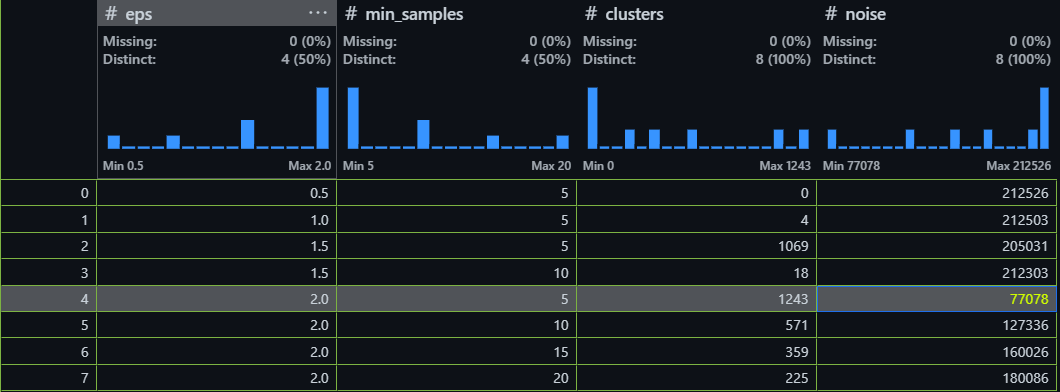

In [30]:
ct = ColumnTransformer(
    [
        ('scaling',RobustScaler(),scale_col),
        ('onehot',OneHotEncoder(sparse_output=False,handle_unknown='ignore'),onehot_col)
    ]
)
X = ct.fit_transform(df_train)

In [ ]:
# 여러 조합을 리스트로 준비
params = [
    {'eps': 0.5, 'min_samples': 5},
    {'eps': 1.0, 'min_samples': 5},
    {'eps': 1.5, 'min_samples': 5},
    {'eps': 1.5, 'min_samples': 10},
    {'eps': 2.0, 'min_samples': 5},
    {'eps': 2.0, 'min_samples': 10},
    {'eps': 2.0, 'min_samples': 15},
    {'eps': 2.0, 'min_samples': 20},
]

results = []

for param in params:
    dbscan = DBSCAN(eps=param['eps'], min_samples=param['min_samples'])
    labels = dbscan.fit_predict(X)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # 군집 개수
    n_noise = list(labels).count(-1)  # 이상치 개수
    results.append({
        'eps': param['eps'],
        'min_samples': param['min_samples'],
        'clusters': n_clusters,
        'noise': n_noise,
        'results':labels
    })

df_results = pd.DataFrame(results)
df_results

,eps,min_samples,clusters,noise
0,0.5,5,0,212526
1,1.0,5,4,212503
2,1.5,5,1069,205031
3,1.5,10,18,212303
4,2.0,5,1243,77078
5,2.0,10,571,127336
6,2.0,15,359,160026
7,2.0,20,225,180086


In [32]:
# df_train['cluster'] = labels
# df_train.groupby('cluster').mean(numeric_only=True)

In [ ]:
from sklearn.metrics import silhouette_score


# 결과 저장용 리스트
results2 = []

# 탐색 범위 정의
eps_list = [0.5, 1.0, 1.5, 2.0, 2.5]
min_samples_list = [3, 5, 10]

for eps in eps_list:
    for min_samples in min_samples_list:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        # silhouette score는 2개 이상 군집이 있어야 계산 가능
        if n_clusters > 1:
            sil_score = silhouette_score(X, labels)
        else:
            sil_score = -1

        results2.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'silhouette': sil_score,
            'labels':labels
        })
df_results = pd.DataFrame(results2)

In [33]:
#처리 데이터 프레임으로 훈련데이터에 레이블 적용  이상치 -1 제거
# df_train['cluster'] = labels
# df_cleaned = df_train[labels != -1].drop(columns=['cluster'])
# X = ct.fit_transform(df_cleaned)
# dbscan = DBSCAN(eps=1.5,min_samples=5)
# labels = dbscan.fit_predict(X)